# Visual Wake Words (VWW) Project - Phase 2: Training & Evaluation
**Goal:** Acquire real data (INRIA Person Dataset), train MobileNetV2/V3 models, and evaluate performance.
**Environment:** Google Colab / TensorFlow 2.x

## 1. Setup & Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import shutil
import tarfile
import urllib.request

# Check GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: False


## 2. Dataset Acquisition (INRIA Person Dataset)
We will use the **INRIA Person Dataset** as a high-quality, manageable alternative to COCO.
*   **Source:** http://pascal.inrialpes.fr/data/human/
*   **Size:** ~970 MB (Compressed)
*   **Task:** Person vs. Background (Binary Classification)

In [2]:
# Define paths
# Use Archive.org link as the original INRIA link is unstable
dataset_url = "https://web.archive.org/web/20190301110434/ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar"
archive_path = "INRIAPerson.tar"
extract_path = "INRIAPerson_Raw"
final_dataset_dir = pathlib.Path("vww_dataset")

# 1. Download
if not os.path.exists(archive_path) and not os.path.exists(extract_path):
    print("Downloading INRIA Person Dataset (this may take a few minutes)...")
    # Using wget command for Colab/Linux, fallback to urllib for local
    # Added --no-check-certificate for archive.org stability
    if os.system(f"wget --no-check-certificate {dataset_url} -O {archive_path}") != 0:
        print("wget failed, trying urllib...")
        try:
            urllib.request.urlretrieve(dataset_url, archive_path)
            print("Download complete.")
        except Exception as e:
            print(f"Download failed: {e}")
            print("Please manually download 'INRIAPerson.tar' and upload it to Colab.")
else:
    print("Archive already exists or extracted.")

# 2. Extract
if not os.path.exists(extract_path):
    if os.path.exists(archive_path):
        print("Extracting...")
        try:
            with tarfile.open(archive_path) as tar:
                tar.extractall(extract_path)
            print("Extraction complete.")
        except tarfile.ReadError:
            print("Error: The downloaded file might be corrupted. Please try downloading again.")
    else:
        print("Archive not found, cannot extract.")
else:
    print("Data already extracted.")

Extracting...
Extracting...


/tmp/ipython-input-3934410394.py:30: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_path)


Extraction complete.


## 3. Data Restructuring
We need to convert the INRIA structure into the standard Keras `image_dataset_from_directory` format:
```
vww_dataset/
  train/
    person/
    not_person/
  validation/
    person/
    not_person/
```
INRIA structure mapping:
*   `Train/pos` -> `train/person`
*   `Train/neg` -> `train/not_person`
*   `Test/pos` -> `validation/person`
*   `Test/neg` -> `validation/not_person`

In [3]:
def organize_dataset(source_root, dest_root):
    if dest_root.exists():
        print(f"Destination {dest_root} already exists. Skipping organization.")
        return

    print(f"Organizing data from {source_root} to {dest_root}...")
    
    # INRIA folder names
    # Note: The extracted folder is usually 'INRIAPerson' inside 'INRIAPerson_Raw'
    inria_root = pathlib.Path(source_root) / "INRIAPerson"
    
    splits = {
        'train': 'Train',
        'validation': 'Test'
    }
    labels = {
        'person': 'pos',
        'not_person': 'neg'
    }

    for split_name, inria_split in splits.items():
        for label_name, inria_label in labels.items():
            # Source path
            src_dir = inria_root / inria_split / inria_label
            # Dest path
            dest_dir = dest_root / split_name / label_name
            dest_dir.mkdir(parents=True, exist_ok=True)
            
            # Copy files
            # INRIA images are .png or .jpg
            files = list(src_dir.glob('*.png')) + list(src_dir.glob('*.jpg'))
            print(f"Copying {len(files)} files to {dest_dir}...")
            
            for f in files:
                shutil.copy2(f, dest_dir / f.name)
                
    print("Data organization complete.")

organize_dataset(extract_path, final_dataset_dir)

Organizing data from INRIAPerson_Raw to vww_dataset...
Copying 614 files to vww_dataset/train/person...
Copying 1218 files to vww_dataset/train/not_person...
Copying 1218 files to vww_dataset/train/not_person...
Copying 288 files to vww_dataset/validation/person...
Copying 453 files to vww_dataset/validation/not_person...
Data organization complete.
Copying 288 files to vww_dataset/validation/person...
Copying 453 files to vww_dataset/validation/not_person...
Data organization complete.


## 4. Data Loading & Preprocessing
Same pipeline as Phase 1.
*   Resize to 96x96
*   Normalize to [-1, 1]
*   Augmentation for training

In [4]:
IMG_SIZE = 96
BATCH_SIZE = 32

print(f"Loading data from: {final_dataset_dir}")

train_ds = tf.keras.utils.image_dataset_from_directory(
    final_dataset_dir / 'train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    final_dataset_dir / 'validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Preprocessing functions
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image / 127.5) - 1.0
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Loading data from: vww_dataset
Found 1832 files belonging to 2 classes.
Found 741 files belonging to 2 classes.
Found 741 files belonging to 2 classes.


## 5. Model Definition
We define both MobileNetV2 (alpha=0.35) and MobileNetV3-Small for comparison.

In [5]:
def create_mobilenet_v2_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.35
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_mobilenet_v3_model():
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        minimalistic=False
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

model_v2 = create_mobilenet_v2_model()
model_v2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_v3 = create_mobilenet_v3_model()
model_v3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Models created.")

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Models created.
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Models created.


## 6. Training
We will train both models for 10 epochs.
*   **Callbacks:**
    *   `ModelCheckpoint`: Save the best model.
    *   `EarlyStopping`: Stop if validation loss doesn't improve.

In [6]:
EPOCHS = 10

# Callbacks
callbacks_v2 = [
    tf.keras.callbacks.ModelCheckpoint('best_model_v2.keras', save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

callbacks_v3 = [
    tf.keras.callbacks.ModelCheckpoint('best_model_v3.keras', save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

print("Training MobileNetV2...")
history_v2 = model_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_v2
)

print("\nTraining MobileNetV3-Small...")
history_v3 = model_v3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_v3
)

Training MobileNetV2...
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.8271 - loss: 0.3892 - val_accuracy: 0.9217 - val_loss: 0.1891
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.8271 - loss: 0.3892 - val_accuracy: 0.9217 - val_loss: 0.1891
Epoch 2/10
 2/58 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9375 - loss: 0.1486 Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.9415 - loss: 0.1499 - val_accuracy: 0.9325 - val_loss: 0.1631
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.9415 - loss: 0.1499 - val_accuracy: 0.9325 - val_loss: 0.1631
Epoch 3/10
 2/58 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9141 - loss: 0.1722 Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.9554 - loss: 0.1178 - val_accuracy: 0.9352 - val_loss: 0.1529
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.9554 - loss: 0.1178 - val_accuracy: 0.9352 - val_loss: 0.1529
Epoch 4/10
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step -

## 7. Evaluation & Comparison
Plot accuracy and loss curves to compare the two architectures.

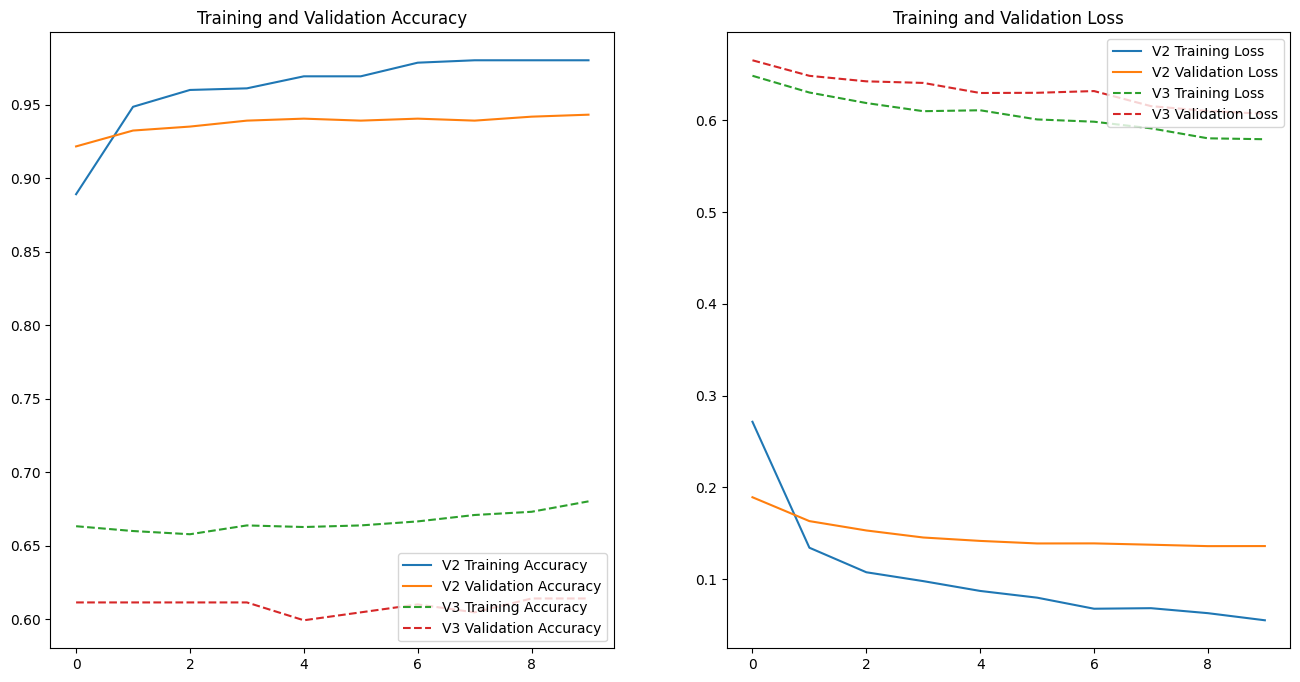

In [7]:
acc_v2 = history_v2.history['accuracy']
val_acc_v2 = history_v2.history['val_accuracy']
loss_v2 = history_v2.history['loss']
val_loss_v2 = history_v2.history['val_loss']

acc_v3 = history_v3.history['accuracy']
val_acc_v3 = history_v3.history['val_accuracy']
loss_v3 = history_v3.history['loss']
val_loss_v3 = history_v3.history['val_loss']

epochs_range_v2 = range(len(acc_v2))
epochs_range_v3 = range(len(acc_v3))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_v2, acc_v2, label='V2 Training Accuracy')
plt.plot(epochs_range_v2, val_acc_v2, label='V2 Validation Accuracy')
plt.plot(epochs_range_v3, acc_v3, label='V3 Training Accuracy', linestyle='--')
plt.plot(epochs_range_v3, val_acc_v3, label='V3 Validation Accuracy', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_v2, loss_v2, label='V2 Training Loss')
plt.plot(epochs_range_v2, val_loss_v2, label='V2 Validation Loss')
plt.plot(epochs_range_v3, loss_v3, label='V3 Training Loss', linestyle='--')
plt.plot(epochs_range_v3, val_loss_v3, label='V3 Validation Loss', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()